# Test et valuation of multiple supervised classification solution
The dataset is [basics statistics](https://leagueoflegends.fandom.com/wiki/List_of_champions/Base_statistics) of [League of Legend](https://www.leagueoflegends.com/fr-fr/) champions.

The 2 targets are :
  - recommanded [lanes](https://leagueoflegends.fandom.com/wiki/Lanes) for the champion in normal game mode (defines on which of the 5 lanes the champion is suited to play), encoded in 5 sub-targets.
  - champion's [class](https://leagueoflegends.fandom.com/wiki/Champion_classes) (define the general role of the champion)

## sommaire
- [install/import](#install--import)
  - [Data description](#Data-description)
- [Data preprocessing](#dataPreprocessing)
  - [Feature selection](#feature-selection)
- [Classification](#classification)
  - [k-nearest neighbors](#k-nearest-neighbors)
    - [Feature Scaling](#feature-scaling)
    - [KNN training and valuation](#knn-training-and-valuation)
  - Naive Bayes
    - Naive Bayes training and valuation
  - Decision Trees
    - Decision Trees training and valuation
- Conclusion
- Classification of custom entity 

## install / import

In [1]:
#%pip install scikit-learn
#%pip install numpy
#%pip install pandas
#%pip install matplotlib
#%pip install seaborn

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn

In [2]:
df = pd.read_csv("./projetStatsChampsLol.csv")
df.head

<bound method NDFrame.head of           Name   HP    HP+   HP5  HP5+   MP   MP+    MP5  MP5+  AD  ...   MR+  \
0       Aatrox  650  114.0  3.00  1.00    0   0.0   0.00  0.00  60  ...  2.05   
1         Ahri  590  104.0  2.50  0.60  418  25.0   8.00  0.80  53  ...  1.30   
2        Akali  570  119.0  9.00  0.90  200   0.0  50.00  0.00  62  ...  2.05   
3       Akshan  630  107.0  3.75  0.65  350  40.0   8.20  0.70  52  ...  1.30   
4      Alistar  685  120.0  8.50  0.85  350  40.0   8.50  0.80  62  ...  2.05   
..         ...  ...    ...   ...   ...  ...   ...    ...   ...  ..  ...   ...   
166       Zeri  630  110.0  3.25  0.70  250  45.0   6.00  0.80  56  ...  1.30   
167      Ziggs  606  106.0  6.50  0.60  480  23.5   8.00  0.80  55  ...  1.30   
168     Zilean  574   96.0  5.50  0.50  452  50.0  11.35  0.80  52  ...  1.30   
169        Zoe  630  106.0  7.50  0.60  425  25.0   8.00  0.65  58  ...  1.30   
170       Zyra  574   93.0  5.50  0.50  418  25.0   7.00  0.80  53  ...  1.30  

## Data description
Get the dataset and quick check of eventual failure.
- Features presentation:
  - champion name, useless for classification but more readable than entity numbers for graphical representation 
  - variables annotated with '+' indicate the scalling value added to the initial one for each champion level, from 1 to 18 over the course of the game.
  - HP : number of health points.
    - HP5 : number of health points recovered per 5 seconds
  - MP : Mana points, or energy point for some champs
    - MP5 : number of mana/energy points recovered per 5 seconds
  - AD : Attack Damage, physical pre-mitigation damage dealt when using basic attack (right click)
  - AS : Attack Speed, maximum attack the champ can deal per second 
    - the "+" scalling value is a percentage add to the implied "Bonus Attack Speed" value. It result that the **effective AS** = **basic AS***(1+**Bonus AS**) 
  - AR : ARmor, parameter of a non-linear function that calculates physical incurred damage (physical post-mitigated damage) as a function of physical pre-mitigation damage
  - MR : Magic Resistance, same as armor but for magic damages.
  - MS : Movement Speed, number of game-distance unit traveled per second
  - ranged : variable affecting access to and use of certain in-game objects.
  - range : radius around the champion in which basic attacks can be made.

  "Ranged" is the only non-numerical var but is directly linked to the "range" one, it's used to avoid confusion between certain champions: for example, Urgot is ranged but with a small 350 range for his category, while Lillia is not ranged, even though she has a range of 325. This variable is really important, as some in-game items are only available for one of the two categories.

Target presentation  
- Lanes : the lanes normally define the player's game objective or gameplay for the current match.
  - "Top" : starts on the upper track, often has two types of gameplay: splitpush or engaging teamfights
  - "Jgl" : plays in the jungle, collecting resources via neutral monsters, his goal is to help the 3 lanes via ganks to take advantage of a numerical advantage. he must also prepare the ground to defeat epic monsters with his team regularly in the match. 
  - "Mid" : starts on the middle path, has three objectives: gank side lanes (top and bot), help the Jgl (jungler) vanquish epic monsters, eliminate problematic targets in teamfights.
  - "Bot" : starts on the lower track, almost exclusively AD carry (marksman) or AP carry (battlemage). the aim is to gain as many resources as possible to be able to DPS effectively in teamfights or push quickly.
  - "Sup" : support, his goal is to help his Bot gain resources considerably in the first few minutes of the game, and then he goes on to help all the lanes. He normally leaves the resources to his allies.
- Class : 
  - define the general role of the champion  
  - "marksman"   : use their long range damage and basic attacks to DPS (deal constant Damage Per Second) enemies 
  - "assassin"   : able to penetrate enemy defenses to eliminate weak targets, thanks to their high mobility and capacity to avoid incoming damage
  - "burst"      : mage whose aim is to eliminate one or two targets with a combo of a few spells, then stand back
  - "diver"      : able to penetrate enemy defenses to eliminate weak targets, thanks to their high mobility 
  - "vanguard"   : lead the charge for their team and specialize at bringing the action, by high resistance, mobility and control capabilities
  - "specialist" : psychological zoners, control enemy pathing by using special positioning or zone spells to dissuade an opponent from approaching, at the risk of exposing themselves to a violent counter-attack
  - "juggernaut" : melee titans who excel at both dealing and taking significant amounts of damage, but get low ange and bad mobility
  - "skirmisher" : also named Duelist, built to win a 1v1 against any enemy and survive if others arrive, thanks to strong defensive or holding capabilities
  - "battlemage" : mage very efficient in short range damage areas
  - "enchanter"  : amplifying their allies' effectiveness, by healing or boost them
  - "catcher"    : control enemy movements, but allies-dependent because of low damage resistance or low damages
  - "warden"     : defensive tanks. Wardens stand steadfast, seeking to hold the line by persistently locking down any on-comers who try to pass them.
  - "artillery"  : mage who excel in long range magic damage
 
[glossary](https://www.progressersurleagueoflegends.fr/guides/guides-connaissances/lexique-league-of-legends/) : Splitpush, teamfights, jungle, tank, gank, DPS, carry, etc.

# Data preprocessing

## Feature selection

**Check for missing values :**
no missing values.

In [3]:
print(df.isna().sum())

Name      0
HP        0
HP+       0
HP5       0
HP5+      0
MP        0
MP+       0
MP5       0
MP5+      0
AD        0
AD+       0
AS        0
AS+       0
AR        0
AR+       0
MR        0
MR+       0
MS        0
Ranged    0
Range     0
isTop     0
isJgl     0
isMid     0
isBot     0
isSup     0
Class     0
dtype: int64


In [4]:
qualitative_vars = ["Ranged","Class"]
target_vars = ["isTop","isJgl","isMid","isBot","isSup"]
quantitative_vars = [col for col in df.columns if col not in qualitative_vars + target_vars + ["Name"]]

df_encoded = pd.DataFrame(pd.get_dummies(df, columns=['Class'],dtype=int))
columns_to_drop = ["Name"]
df_encoded = df_encoded.drop(columns=columns_to_drop)
qualitative_vars_encoded = [col for col in df_encoded.columns if col not in quantitative_vars + target_vars]
print(qualitative_vars_encoded)

['Ranged', 'Class_artillery', 'Class_assassin', 'Class_battlemage', 'Class_burst', 'Class_catcher', 'Class_diver', 'Class_enchanter', 'Class_juggernaut', 'Class_marksman', 'Class_skirmisher', 'Class_specialist', 'Class_vanguard', 'Class_warden']


In [5]:
X_quantitative=df_encoded[quantitative_vars]
X_qualitative=df_encoded[qualitative_vars_encoded]
X_total = pd.concat([X_quantitative,X_qualitative], axis=1)
Y = df[target_vars]
print(X_quantitative.columns)
print(X_qualitative.columns)
print(Y.columns)

Index(['HP', 'HP+', 'HP5', 'HP5+', 'MP', 'MP+', 'MP5', 'MP5+', 'AD', 'AD+',
       'AS', 'AS+', 'AR', 'AR+', 'MR', 'MR+', 'MS', 'Range'],
      dtype='object')
Index(['Ranged', 'Class_artillery', 'Class_assassin', 'Class_battlemage',
       'Class_burst', 'Class_catcher', 'Class_diver', 'Class_enchanter',
       'Class_juggernaut', 'Class_marksman', 'Class_skirmisher',
       'Class_specialist', 'Class_vanguard', 'Class_warden'],
      dtype='object')
Index(['isTop', 'isJgl', 'isMid', 'isBot', 'isSup'], dtype='object')


In [6]:
value_counts_dict = {}

for var in qualitative_vars_encoded:
    counts = df_encoded[var].value_counts()
    value_counts_dict[var] = counts

# un DataFrame du dictionnaire pour un affichage plus propre
value_counts_df = pd.DataFrame(value_counts_dict)
value_counts_df.T

,0,1
Ranged,90,81
Class_artillery,165,6
Class_assassin,154,17
Class_battlemage,160,11
Class_burst,155,16
Class_catcher,164,7
Class_diver,155,16
Class_enchanter,162,9
Class_juggernaut,157,14
Class_marksman,146,25


In [7]:
print(df_encoded.columns)

Index(['HP', 'HP+', 'HP5', 'HP5+', 'MP', 'MP+', 'MP5', 'MP5+', 'AD', 'AD+',
       'AS', 'AS+', 'AR', 'AR+', 'MR', 'MR+', 'MS', 'Ranged', 'Range', 'isTop',
       'isJgl', 'isMid', 'isBot', 'isSup', 'Class_artillery', 'Class_assassin',
       'Class_battlemage', 'Class_burst', 'Class_catcher', 'Class_diver',
       'Class_enchanter', 'Class_juggernaut', 'Class_marksman',
       'Class_skirmisher', 'Class_specialist', 'Class_vanguard',
       'Class_warden'],
      dtype='object')


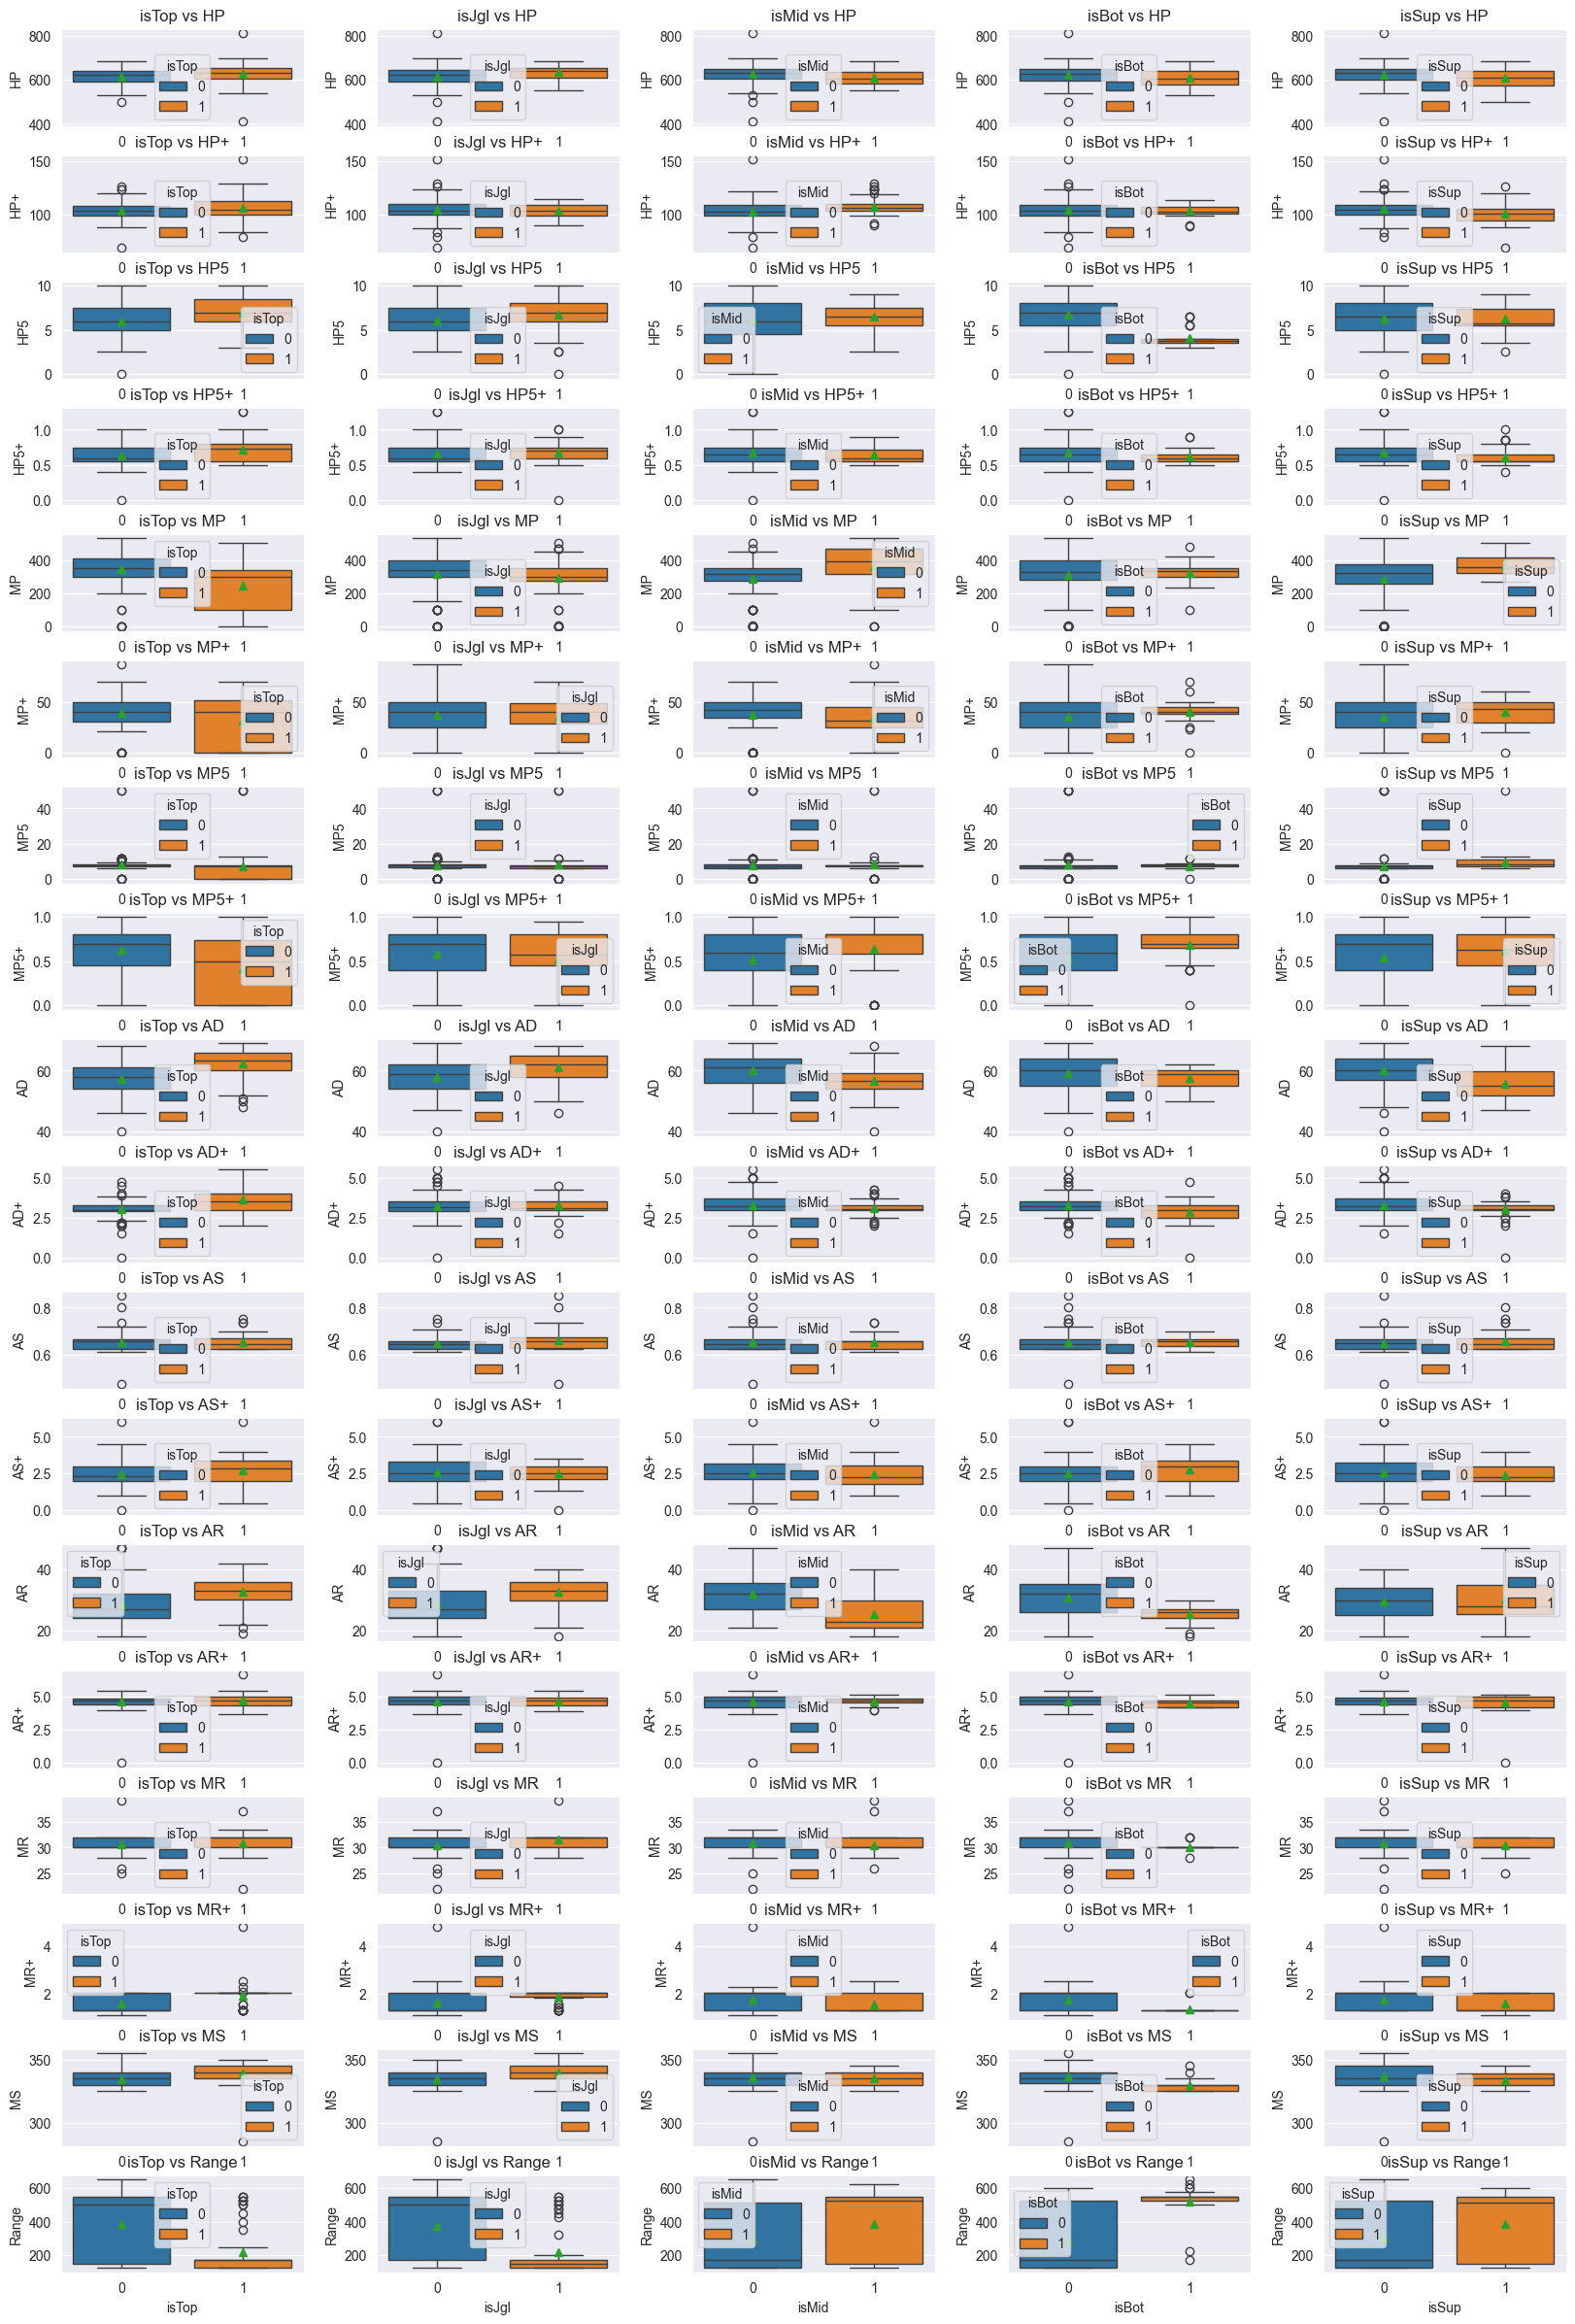

In [8]:
plt.figure(figsize=(20,30))
plt.tight_layout()
plt.subplots_adjust(wspace=0.3,hspace=0.3)
# Boucler à travers chaque variable cible
for j, var in enumerate(X_quantitative):
    # Boucler à travers chaque variable quantitative dans le groupe
    for i, targ in enumerate(Y):
        plt.subplots_adjust(wspace=0.3,hspace=0.3)
        # Tracer le boxplot
        plt.subplot(18,5,j*5+i+1) # Position du subplot
        sns.boxplot(y=df_encoded[var], x=df_encoded[targ], hue=df_encoded[targ], showmeans=True)
        plt.title(f'{targ} vs {var}')
        plt.xlabel(targ)
        plt.ylabel(var)
# Afficher les boxplots du groupe actuel
plt.show()

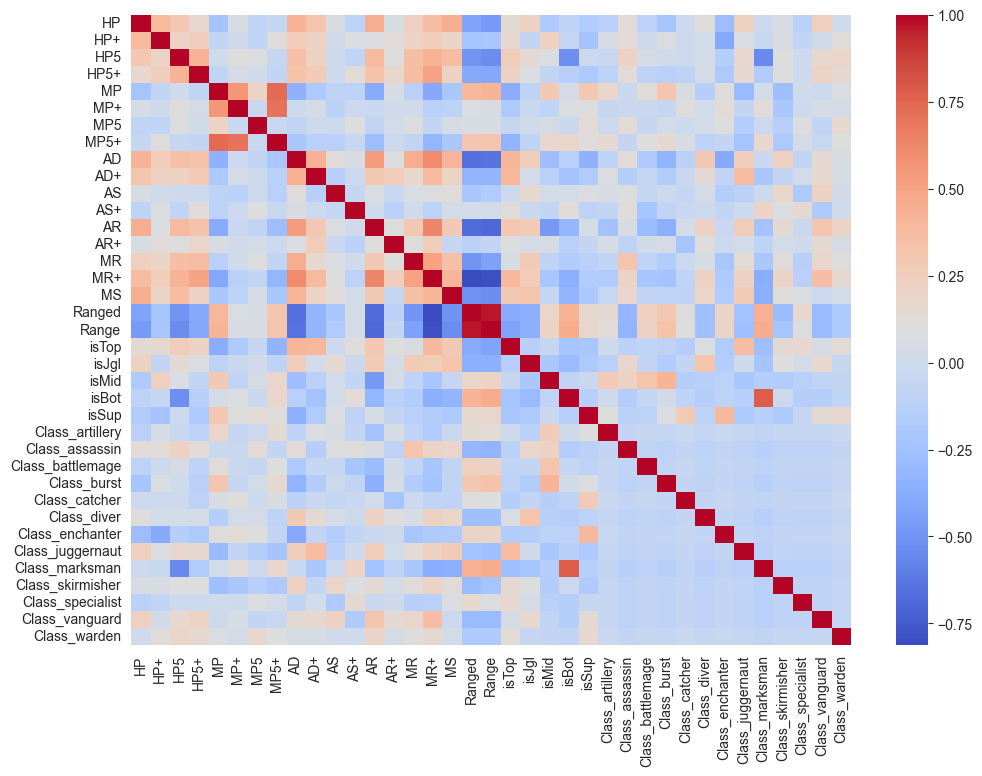

In [9]:
# Créer le heatmap avec les noms de colonnes
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(df_encoded.corr(), cmap='coolwarm', fmt=".2f",
                      xticklabels=df_encoded.columns, yticklabels=df_encoded.columns)

# Ajuster les marges pour éviter la coupure des étiquettes
plt.subplots_adjust(left=0.15, bottom=0.25)

# Afficher le heatmap
plt.show()

In [10]:
corr_matrix = df_encoded.corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.8)]
print(to_drop)

['Ranged', 'Range']


In [11]:
qualitative_vars_encoded = [col for col in qualitative_vars_encoded if col not in ["Ranged"]]
X_quantitative=df_encoded[quantitative_vars]
X_qualitative=df_encoded[qualitative_vars_encoded]
X_total = pd.concat([X_quantitative,X_qualitative], axis=1)
Y = df[target_vars]
print(X_quantitative.columns)
print(X_qualitative.columns)
print(Y.columns)

Index(['HP', 'HP+', 'HP5', 'HP5+', 'MP', 'MP+', 'MP5', 'MP5+', 'AD', 'AD+',
       'AS', 'AS+', 'AR', 'AR+', 'MR', 'MR+', 'MS', 'Range'],
      dtype='object')
Index(['Class_artillery', 'Class_assassin', 'Class_battlemage', 'Class_burst',
       'Class_catcher', 'Class_diver', 'Class_enchanter', 'Class_juggernaut',
       'Class_marksman', 'Class_skirmisher', 'Class_specialist',
       'Class_vanguard', 'Class_warden'],
      dtype='object')
Index(['isTop', 'isJgl', 'isMid', 'isBot', 'isSup'], dtype='object')


# Classification
## k-nearest neighbors

== expliquer le KNN

### Feature scaling

In [12]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_quantitative)
scaled_quantitative = min_max_scaler.transform(X_quantitative)
X_KNN = pd.concat([pd.DataFrame(scaled_quantitative),X_qualitative], axis=1)
X_KNN.columns = X_KNN.columns.astype(str)
pd.DataFrame(X_KNN)

,0,1,2,3,4,5,6,7,8,9,...,Class_burst,Class_catcher,Class_diver,Class_enchanter,Class_juggernaut,Class_marksman,Class_skirmisher,Class_specialist,Class_vanguard,Class_warden
0,0.6000,0.544484,0.300,0.80,0.000000,0.000000,0.000,0.00,0.689655,0.909091,...,0,0,0,0,1,0,0,0,0,0
1,0.4500,0.423488,0.250,0.48,0.788679,0.287356,0.160,0.80,0.448276,0.545455,...,1,0,0,0,0,0,0,0,0,0
2,0.4000,0.604982,0.900,0.72,0.377358,0.000000,1.000,0.00,0.758621,0.600000,...,0,0,0,0,0,0,0,0,0,0
3,0.5500,0.459786,0.375,0.52,0.660377,0.459770,0.164,0.70,0.413793,0.545455,...,0,0,0,0,0,1,0,0,0,0
4,0.6875,0.617082,0.850,0.68,0.660377,0.459770,0.170,0.80,0.758621,0.681818,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,0.5500,0.496085,0.325,0.56,0.471698,0.517241,0.120,0.80,0.551724,0.363636,...,0,0,0,0,0,1,0,0,0,0
167,0.4900,0.447687,0.650,0.48,0.905660,0.270115,0.160,0.80,0.517241,0.563636,...,0,0,0,0,0,0,0,0,0,0
168,0.4100,0.326690,0.550,0.40,0.852830,0.574713,0.227,0.80,0.413793,0.545455,...,0,0,0,0,0,0,0,1,0,0
169,0.5500,0.447687,0.750,0.48,0.801887,0.287356,0.160,0.65,0.620690,0.600000,...,1,0,0,0,0,0,0,0,0,0


For each p in [1,2,3] and k in [1,3,5,7], split intro 4 datasets: X_train, y_train, X_test, y_test, with a 60% train / 40% test

### KNN training and valuation

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score
import numpy as np

# Initialiser le classificateur KNN avec les paramètres par défaut
KNN = KNeighborsClassifier()
accuracies = np.zeros((len(Y.columns), 3, 4))
recalls = np.zeros((len(Y.columns), 3, 4))

for i, targ in enumerate(Y.columns):
    X_train, X_test, y_train, y_test = train_test_split(X_KNN, Y[targ], test_size=0.2, stratify=Y[targ])

    for ip, p in enumerate(range(1, 4)):
        for ik, k in enumerate(range(1, 9, 2)):
            KNN = KNeighborsClassifier(n_neighbors=k, weights="distance", p=p)
            KNN.fit(X_train, y_train)
            prediction = KNN.predict(X_test)
            accuracies[i, ip, ik] = accuracy_score(y_test, prediction)
            recalls[i, ip, ik] = recall_score(y_test, prediction)
            
mean_accuracies = np.zeros((3, 4))# mean accu for each targ for p(1,2,3),k(1,3,5,7)
mean_recalls = np.zeros((3, 4))
for ip, p in enumerate(range(1, 4)):
    for ik, k in enumerate(range(1, 9, 2)):
        mean_accuracy = 0
        mean_recall = 0
        for i, targ in enumerate(Y.columns):
            mean_accuracy+=accuracies[i, ip, ik]
            mean_recall+=recalls[i, ip, ik]
        mean_accuracy/=len(Y.columns)
        mean_recall/=len(Y.columns)
        mean_accuracies[ip, ik] = mean_accuracy
        mean_recalls[ip, ik] = mean_recall
        
mean_accuracies = pd.DataFrame(mean_accuracies)
mean_accuracies.columns = ["1", "3", "5", "7"]
mean_accuracies = mean_accuracies.transpose()
mean_accuracies.columns = ["1", "2", "3"]
print(mean_accuracies)
mean_recalls = pd.DataFrame(mean_recalls)
mean_recalls.columns = ["1", "3", "5", "7"]
mean_recalls = mean_recalls.transpose()
mean_recalls.columns = ["1", "2", "3"]
print(mean_recalls)

          1         2         3
1  0.817143  0.822857  0.822857
3  0.828571  0.828571  0.822857
5  0.840000  0.828571  0.817143
7  0.845714  0.828571  0.822857
          1         2         3
1  0.680303  0.741414  0.758081
3  0.705859  0.683636  0.665455
5  0.724747  0.711414  0.726566
7  0.744747  0.709899  0.709899


,isTop,isJgl,isMid,isBot,isSup
0,"(0.7142857142857143, 1, 7)","(0.8571428571428571, 3, 3)","(0.8857142857142857, 2, 7)","(0.9428571428571428, 3, 7)","(0.8571428571428571, 1, 5)"
1,"(0.7142857142857143, 1, 5)","(0.8285714285714286, 2, 3)","(0.8571428571428571, 3, 3)","(0.9428571428571428, 3, 5)","(0.8285714285714286, 2, 7)"
2,"(0.7142857142857143, 1, 1)","(0.8, 1, 7)","(0.8571428571428571, 1, 7)","(0.9428571428571428, 3, 3)","(0.8285714285714286, 2, 5)"
3,"(0.6857142857142857, 3, 1)","(0.8, 1, 5)","(0.8285714285714286, 3, 7)","(0.9428571428571428, 3, 1)","(0.8285714285714286, 1, 7)"
4,"(0.6857142857142857, 2, 7)","(0.7714285714285715, 3, 5)","(0.8285714285714286, 3, 5)","(0.9428571428571428, 2, 7)","(0.8, 3, 7)"
5,"(0.6857142857142857, 2, 3)","(0.7714285714285715, 2, 5)","(0.8285714285714286, 2, 5)","(0.9428571428571428, 2, 5)","(0.8, 3, 5)"


no